2024-10-25 22:26:37,453 - INFO - Using CUDA device 0: NVIDIA TITAN V
2024-10-25 22:26:37,458 - INFO - Memory available: 12.65GB
2024-10-25 22:26:37,471 - INFO - Using CUDA device: NVIDIA TITAN V
2024-10-25 22:26:37,481 - INFO - CUDA Memory Available: 12.65GB
/userdata/jkrolik/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting model evaluation...
Loading test data...


2024-10-25 22:26:38,355 - INFO - Loaded data from /userdata/jkrolik/eeg-sleepstage-classifier/preprocessing/preprocessed_data_201_N1.mat
2024-10-25 22:26:38,356 - INFO - Night 1 data shape: torch.Size([1066, 4, 3000]), Labels shape: torch.Size([1066])
2024-10-25 22:26:38,397 - INFO - Class distribution for night 1: Counter({1: 668, 3: 191, 4: 143, 2: 57, 0: 7})
2024-10-25 22:26:38,624 - INFO - Loaded data from /userdata/jkrolik/eeg-sleepstage-classifier/preprocessing/preprocessed_data_201_N2.mat
2024-10-25 22:26:38,625 - INFO - Night 2 data shape: torch.Size([1013, 4, 3000]), Labels shape: torch.Size([1013])
2024-10-25 22:26:38,644 - INFO - Class distribution for night 2: Counter({1: 564, 3: 196, 4: 146, 0: 78, 2: 29})
2024-10-25 22:26:38,674 - INFO - Combined data shape: torch.Size([2079, 4, 3000])
2024-10-25 22:26:38,676 - INFO - Combined labels shape: torch.Size([2079])
2024-10-25 22:26:38,688 - INFO - Overall class distribution: Counter({1: 1232, 3: 387, 4: 289, 2: 86, 0: 85})
2024

Successfully loaded model parameters

Evaluating Ensemble Model...
Loading model from: /userdata/jkrolik/eeg-sleepstage-classifier/models/new4/best_ensemble_model.pth


/userdata/jkrolik/eeg-sleepstage-classifier/tools/utils.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Successfully loaded Ensemble Model

Evaluating Ensemble Model...


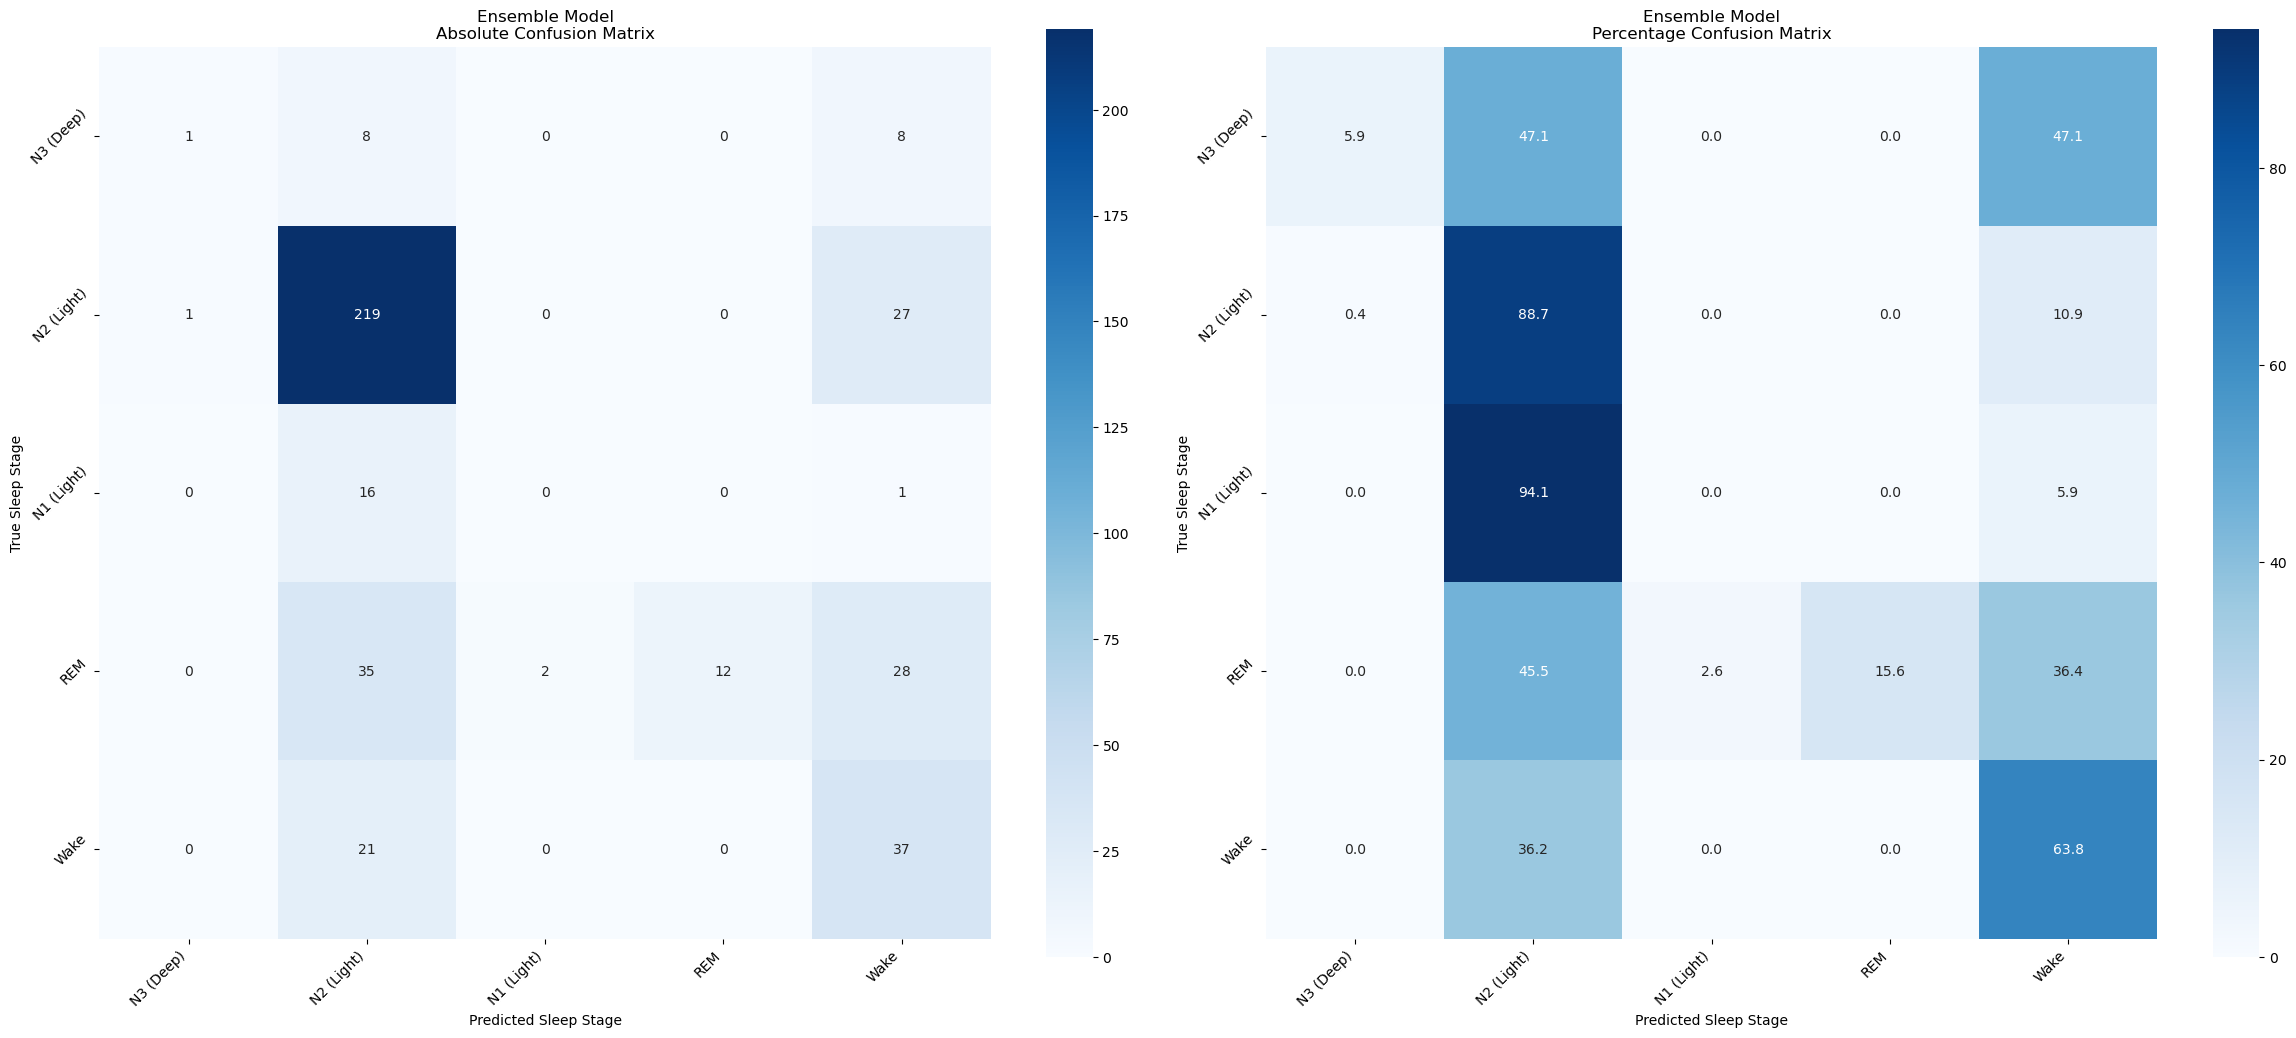


--------------------------------------------------
Ensemble Model Results:
--------------------------------------------------
Overall Accuracy: 64.7%
Macro F1-Score: 32.9%
Weighted F1-Score: 59.5%


,N3 (Deep),N2 (Light),N1 (Light),REM,Wake,Macro Avg,Weighted Avg
Precision,50,73.2%,0,100,36.6%,52.0%,69.1%
Recall,5.9%,88.7%,0,15.6%,63.8%,34.8%,64.7%
F1-Score,10.5%,80.2%,0,27.0%,46.5%,32.9%,59.5%
Support,1700,24700,1700,7700,5800,41600,41600



Evaluating Diverse Ensemble...
Loading model from: /userdata/jkrolik/eeg-sleepstage-classifier/models/new4/best_diverse_ensemble_model.pth


/userdata/jkrolik/eeg-sleepstage-classifier/tools/utils.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Successfully loaded Diverse Ensemble

Evaluating Diverse Ensemble...


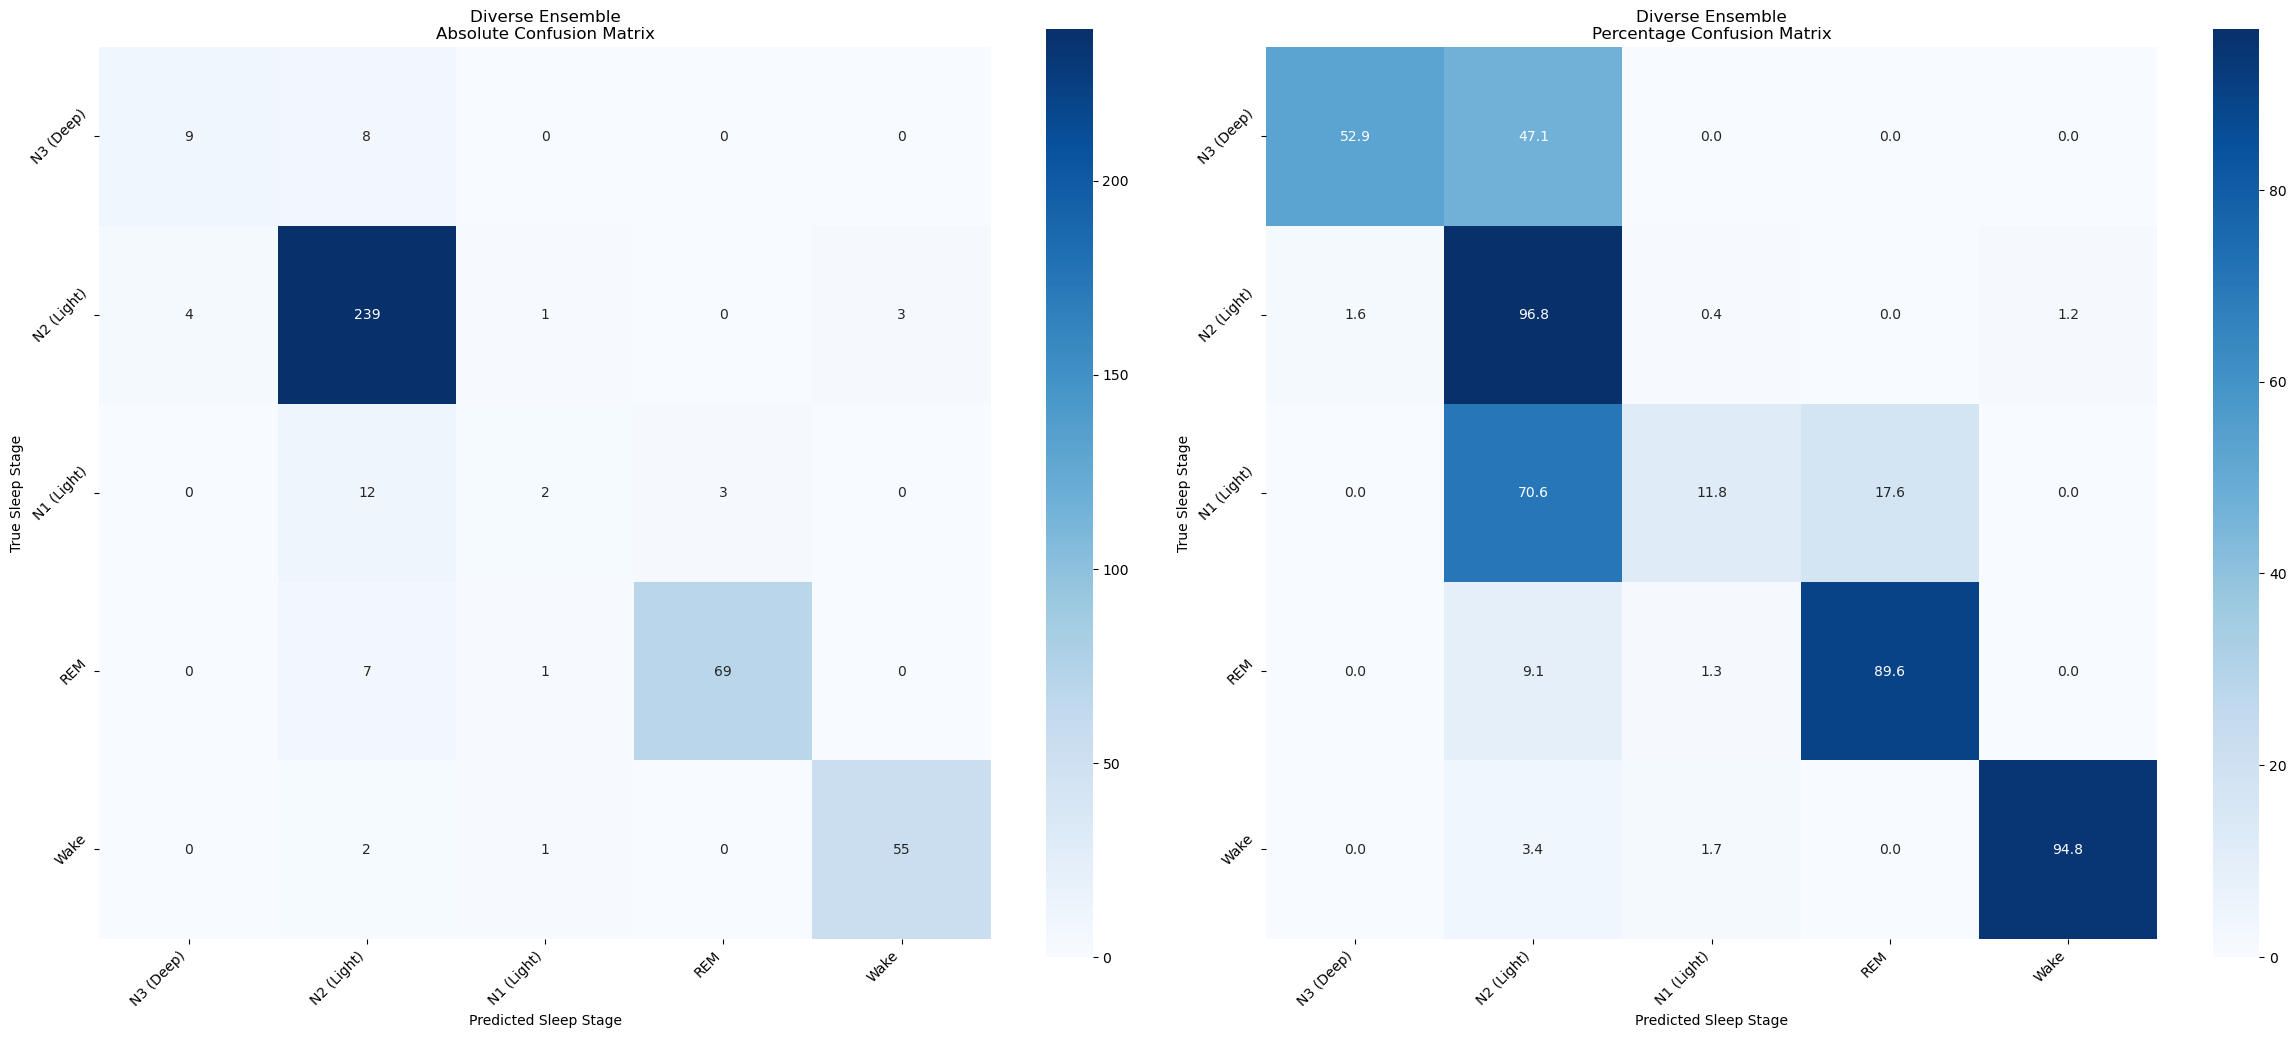


--------------------------------------------------
Diverse Ensemble Results:
--------------------------------------------------
Overall Accuracy: 89.9%
Macro F1-Score: 71.7%
Weighted F1-Score: 88.7%


,N3 (Deep),N2 (Light),N1 (Light),REM,Wake,Macro Avg,Weighted Avg
Precision,69.2%,89.2%,40,95.8%,94.8%,77.8%,88.4%
Recall,52.9%,96.8%,11.8%,89.6%,94.8%,69.2%,89.9%
F1-Score,60,92.8%,18.2%,92.6%,94.8%,71.7%,88.7%
Support,1700,24700,1700,7700,5800,41600,41600



Evaluating Distilled Model...
Loading model from: /userdata/jkrolik/eeg-sleepstage-classifier/models/new4/distilled_model.pth


/userdata/jkrolik/eeg-sleepstage-classifier/tools/utils.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Successfully loaded Distilled Model

Evaluating Distilled Model...


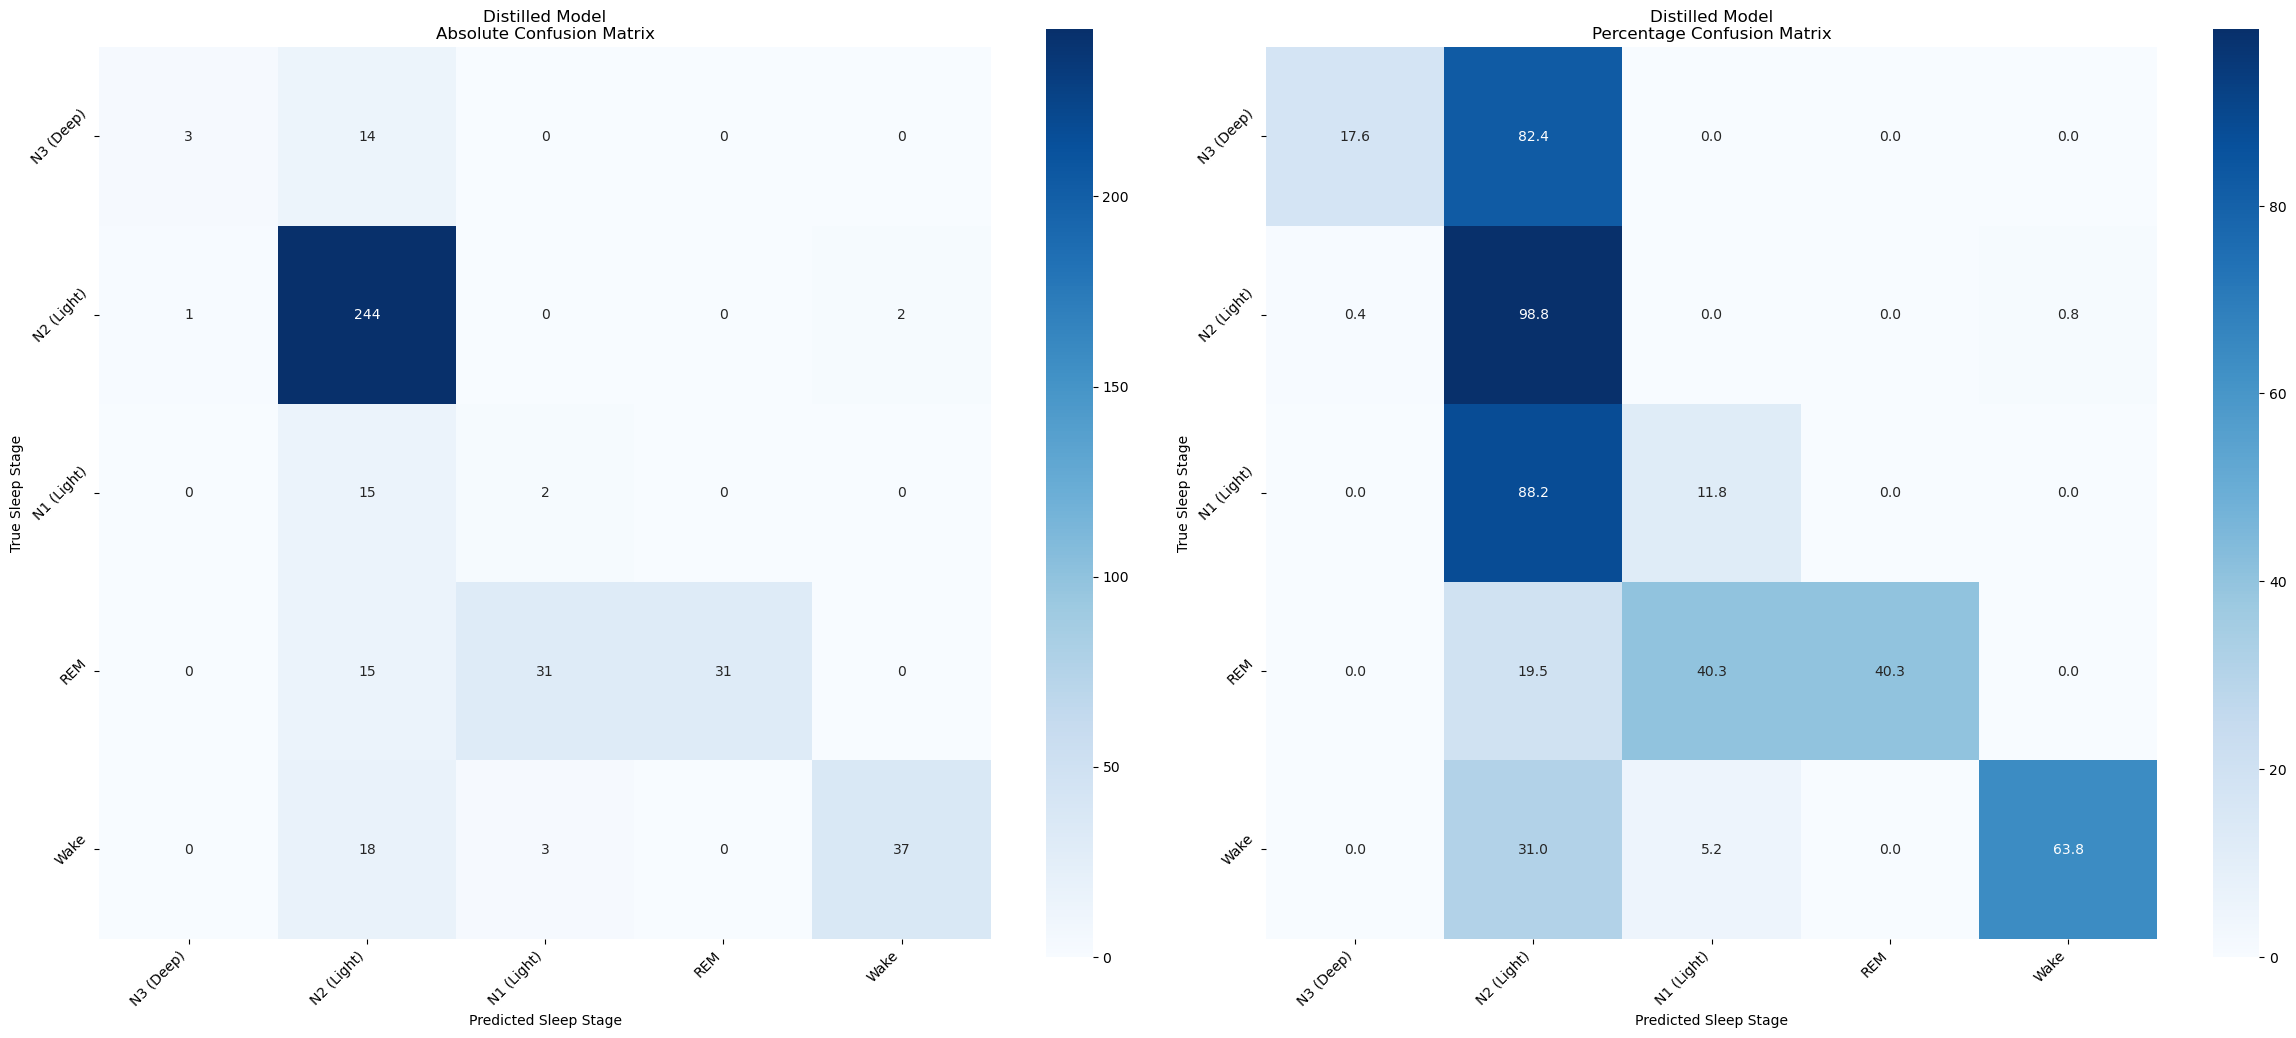


--------------------------------------------------
Distilled Model Results:
--------------------------------------------------
Overall Accuracy: 76.2%
Macro F1-Score: 51.6%
Weighted F1-Score: 75.1%


,N3 (Deep),N2 (Light),N1 (Light),REM,Wake,Macro Avg,Weighted Avg
Precision,75,79.7%,5.6%,100,94.9%,71.0%,82.4%
Recall,17.6%,98.8%,11.8%,40.3%,63.8%,46.5%,76.2%
F1-Score,28.6%,88.2%,7.5%,57.4%,76.3%,51.6%,75.1%
Support,1700,24700,1700,7700,5800,41600,41600



Model Comparison (%):


,Ensemble Model,Diverse Ensemble,Distilled Model
Accuracy,64.7%,89.9%,76.2%
Macro F1,32.9%,71.7%,51.6%
Weighted F1,59.5%,88.7%,75.1%


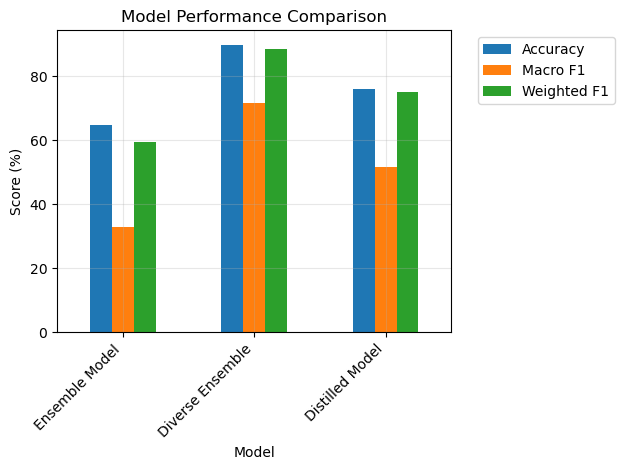

<Figure size 1200x600 with 0 Axes>

In [1]:
import os
import torch
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tools.config import CONFIG, device, cuda_manager
from tools.classes import EnsembleModel, DiverseEnsembleModel, ImprovedSleepdetector
from tools.functions import load_data, prepare_data_multi_night, preprocess_data
from tools.utils import load_model, ensure_dir
from IPython.display import display, HTML
import json

# Configure logging to display in notebook
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class SleepStageEvaluator:
    def __init__(self, model_dir=CONFIG['model_dir']):
        self.model_dir = model_dir
        self.device = device
        # Map class indices to sleep stage names
        self.class_mapping = {
            0: 'N3 (Deep)',
            1: 'N2 (Light)',
            2: 'N1 (Light)',
            3: 'REM',
            4: 'Wake'
        }
        self.class_names = [self.class_mapping[i] for i in range(5)]
        ensure_dir(os.path.join(model_dir, 'test_results'))
        
    def plot_confusion_matrices(self, y_true, y_pred, model_name):
        """Plot both absolute and percentage confusion matrices side by side"""
        # Calculate confusion matrices
        cm_absolute = confusion_matrix(y_true, y_pred)
        cm_percentage = (cm_absolute.astype('float') / 
                        cm_absolute.sum(axis=1)[:, np.newaxis] * 100)
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        
        # Plot absolute confusion matrix
        sns.heatmap(cm_absolute, annot=True, fmt='d', cmap='Blues', square=True,
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax1)
        ax1.set_ylabel('True Sleep Stage')
        ax1.set_xlabel('Predicted Sleep Stage')
        ax1.set_title(f'{model_name}\nAbsolute Confusion Matrix')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax1.get_yticklabels(), rotation=45, ha='right')
        
        # Plot percentage confusion matrix
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', square=True,
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax2)
        ax2.set_ylabel('True Sleep Stage')
        ax2.set_xlabel('Predicted Sleep Stage')
        ax2.set_title(f'{model_name}\nPercentage Confusion Matrix')
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax2.get_yticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save plot
        save_path = os.path.join(self.model_dir, 'test_results', f'{model_name}_confusion_matrices.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        # Display in notebook and save
        display(plt.gcf())
        plt.close()
        
        return cm_absolute, cm_percentage
    
        
    def display_metrics(self, y_true, y_pred, model_name):
        """Calculate and display comprehensive metrics"""
        # Calculate overall metrics
        accuracy = (y_pred == y_true).mean() * 100
        f1_macro = f1_score(y_true, y_pred, average='macro') * 100
        f1_weighted = f1_score(y_true, y_pred, average='weighted') * 100
        
        # Generate detailed classification report
        report = classification_report(y_true, y_pred, 
                                    target_names=self.class_names, 
                                    output_dict=True)
        
        # Create DataFrame from report
        metrics_df = pd.DataFrame(report)
        
        # Print overall metrics
        print(f"\n{'-'*50}")
        print(f"{model_name} Results:")
        print(f"{'-'*50}")
        print(f"Overall Accuracy: {accuracy:.1f}%")
        print(f"Macro F1-Score: {f1_macro:.1f}%")
        print(f"Weighted F1-Score: {f1_weighted:.1f}%")
        
        # Convert metrics to percentages (except support)
        metrics_formatted = metrics_df.copy()
        for col in metrics_formatted.columns:
            if col != 'support':
                metrics_formatted[col] = metrics_formatted[col] * 100
        
        # Create a more readable version of the metrics
        display_metrics = pd.DataFrame(
            index=pd.Index(['Precision', 'Recall', 'F1-Score', 'Support']),
            columns=self.class_names + ['Macro Avg', 'Weighted Avg']
        )
        
        # Fill in the class metrics
        for class_name in self.class_names:
            if class_name in metrics_formatted.columns:
                display_metrics.loc['Precision', class_name] = metrics_formatted.loc['precision', class_name]
                display_metrics.loc['Recall', class_name] = metrics_formatted.loc['recall', class_name]
                display_metrics.loc['F1-Score', class_name] = metrics_formatted.loc['f1-score', class_name]
                display_metrics.loc['Support', class_name] = metrics_formatted.loc['support', class_name]
        
        # Fill in the averages
        for avg in ['macro avg', 'weighted avg']:
            col_name = 'Macro Avg' if avg == 'macro avg' else 'Weighted Avg'
            display_metrics.loc['Precision', col_name] = metrics_formatted.loc['precision', avg]
            display_metrics.loc['Recall', col_name] = metrics_formatted.loc['recall', avg]
            display_metrics.loc['F1-Score', col_name] = metrics_formatted.loc['f1-score', avg]
            display_metrics.loc['Support', col_name] = metrics_formatted.loc['support', avg]
        
        # Create styled version for display
        styled_metrics = display_metrics.style\
            .format(lambda x: f'{x:.1f}%' if pd.notnull(x) and isinstance(x, (int, float)) and x != int(x) else f'{int(x)}' if pd.notnull(x) else '', na_rep='-')\
            .background_gradient(cmap='RdYlGn', subset=pd.IndexSlice[['Precision', 'Recall', 'F1-Score'], :])\
            .set_caption(f"{model_name} Detailed Metrics")
        
        # Display the styled metrics
        display(styled_metrics)
        
        # Save metrics to CSV
        display_metrics.to_csv(os.path.join(self.model_dir, 'test_results', f'{model_name}_metrics.csv'))
        
        return metrics_df
    
    def evaluate_model(self, model, X, X_spectral, y, model_name):
        """Evaluate a single model with comprehensive metrics and visualizations"""
        print(f"\nEvaluating {model_name}...")
        model.eval()
        
        try:
            with torch.no_grad():
                # Generate predictions
                X = X.to(self.device)
                X_spectral = X_spectral.to(self.device)
                outputs = model(X, X_spectral)
                predictions = outputs.argmax(dim=1).cpu().numpy()
                true_labels = y.cpu().numpy()
                
                # Plot confusion matrices
                cm_absolute, cm_percentage = self.plot_confusion_matrices(
                    true_labels, predictions, model_name
                )
                
                # Display and save metrics
                metrics_df = self.display_metrics(true_labels, predictions, model_name)
                
                return {
                    'predictions': predictions,
                    'true_labels': true_labels,
                    'confusion_matrix_absolute': cm_absolute,
                    'confusion_matrix_percentage': cm_percentage,
                    'metrics': metrics_df
                }
                
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            raise  # Add this to see the full error traceback



def compare_models(results, save_dir):
    """Generate and display model comparison"""
    if not results:
        print("No results to compare!")
        return
        
    try:
        # Extract overall metrics for each model
        comparison_data = {
            model_name: {
                'Accuracy': (result['true_labels'] == result['predictions']).mean() * 100,
                'Macro F1': f1_score(result['true_labels'], result['predictions'], average='macro') * 100,
                'Weighted F1': f1_score(result['true_labels'], result['predictions'], average='weighted') * 100
            }
            for model_name, result in results.items()
        }
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(comparison_data).round(1)
        
        # Display comparison
        print("\nModel Comparison (%):")
        styled_comparison = comparison_df.style\
            .format("{:.1f}%")\
            .background_gradient(cmap='RdYlGn')\
            .set_caption("Model Performance Comparison")
        display(styled_comparison)
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        comparison_df.T.plot(kind='bar')
        plt.title('Model Performance Comparison')
        plt.ylabel('Score (%)')
        plt.xlabel('Model')
        plt.xticks(rotation=45, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save and display plot
        plt.savefig(os.path.join(save_dir, 'test_results', 'model_comparison.png'), 
                    dpi=300, bbox_inches='tight')
        display(plt.gcf())
        plt.close()
        
        # Save comparison to CSV
        comparison_df.to_csv(os.path.join(save_dir, 'test_results', 'model_comparison.csv'))
        
    except Exception as e:
        print(f"Error in compare_models: {str(e)}")
        raise  # Add this to see the full error traceback

def load_and_evaluate_models():
    """Load and evaluate all models"""
    try:
        # Load test data
        print("Loading test data...")
        x, y, night_indices = load_data(CONFIG['data_paths'])
        _, _, _, _, _, _, X_test, X_test_spectral, y_test = prepare_data_multi_night(x, y, night_indices)
        X_test, X_test_spectral = preprocess_data(X_test, X_test_spectral)
        
        # Initialize evaluator
        evaluator = SleepStageEvaluator()
        
        # Load model parameters
        try:
            params_path = os.path.join(CONFIG['model_dir'], CONFIG['model_names']['params'])
            with open(params_path, 'r') as f:
                model_params = json.load(f)['model_params']
            print("Successfully loaded model parameters")
        except Exception as e:
            print(f"Error loading model parameters: {str(e)}")
            print("Using default parameters from CONFIG")
            model_params = CONFIG['model_params']['initial']
        
        # Model name mapping
        model_file_mapping = {
            'Ensemble Model': 'ensemble',
            'Diverse Ensemble': 'diverse',
            'Distilled Model': 'distilled'
        }
        
        # Initialize and evaluate models
        results = {}
        for model_name, file_name in model_file_mapping.items():
            try:
                print(f"\nEvaluating {model_name}...")
                
                # Initialize appropriate model
                if model_name == 'Ensemble Model':
                    model = EnsembleModel(model_params)
                elif model_name == 'Diverse Ensemble':
                    model = DiverseEnsembleModel(model_params)
                else:  # Distilled Model
                    model = ImprovedSleepdetector(**model_params)
                
                # Load model weights
                model_path = os.path.join(CONFIG['model_dir'], CONFIG['model_names'][file_name])
                print(f"Loading model from: {model_path}")
                
                if not os.path.exists(model_path):
                    raise FileNotFoundError(f"Model file not found: {model_path}")
                
                model = load_model(model, model_path)
                model = model.to(device)
                print(f"Successfully loaded {model_name}")
                
                # Evaluate model
                results[model_name] = evaluator.evaluate_model(
                    model, X_test, X_test_spectral, y_test, model_name
                )
                
            except Exception as e:
                print(f"Error evaluating {model_name}: {str(e)}")
                continue
        
        if not results:
            print("No models were successfully evaluated!")
            return None
            
        # Compare models only if we have results
        compare_models(results, evaluator.model_dir)
        
        return results
        
    except Exception as e:
        print(f"Error in load_and_evaluate_models: {str(e)}")
        return None



# Run evaluation
print("Starting model evaluation...")
results = load_and_evaluate_models()